## <font color=red>Part 1</font>
The first three cells should be run everytime, even if you start from Part2 or Part3

In [1]:
import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import tifffile as tf
import pandas as pd

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

import caiman.fendo_functions as fendo

2024-07-25 15:10:59.619952: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

### Select file(s) to be processed and read metatadata from Labview
Give also the optical lateral resolution of the system, and the decay time in seconds of the Gcamp you are using. If in a later moment you want to change these values you have to come back here, change it and re-run the cell. 

In [3]:
main_path = '/Users/nicoloaccanto/Documents/Research/Projects/FiberBundle/Analysis/ExampleData'
#'F:/12_2P-FENDO/Analysis'
experiment_day = '2024_06_04'
hour_type = '16_15_55_Photostimulation'

Opt_res = 0.87 # In µm and for binning 1. Depends on optical config. It is 0.87 for objective, Change for GRIN
decay_time = 1.5 # depends on gcamp. It is expressed in seconds. It's around 1.5s for Gcamp7s

data_dir = fendo.data_dir(main_path, experiment_day, hour_type, Opt_res)

/Users/nicoloaccanto/Documents/GitHub/CaImAn/caiman/fendo_functions.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.Frame_rate = float(self.data_imaging.T['Frame rate'])
/Users/nicoloaccanto/Documents/GitHub/CaImAn/caiman/fendo_functions.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.Bin = float(self.data_imaging.T['Binning'])


### Create a smoothed version of the movie
This is especially useful for getting rid of the fiber cores. The motion correction and neuron recognition should work better. 

You can change the __sigma__ parameter for more or less smoothing. Keep it at the minimum for the motion correction to work fine

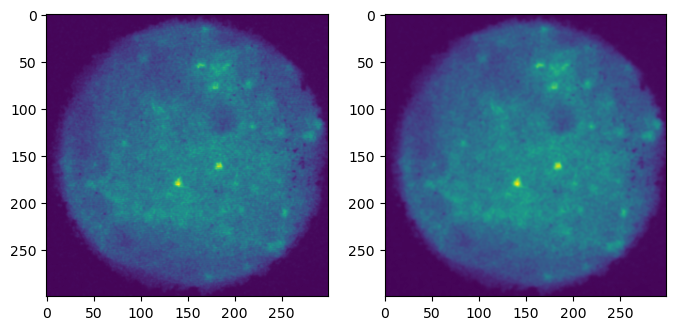

In [4]:
sigma = 0.8 #Change this for more or less smoothing
original_movie, movie_smooth = data_dir.do_smoothing(sigma = sigma) #Import videos and create smoothed version

#figure
fig1, ax1 = plt.subplots(1,2, figsize = [8,8])
ax1[0].imshow(original_movie[0,:,:])
ax1[1].imshow(movie_smooth[0,:,:])

### Play the movie (optional)

In [31]:
#%% Show movie. Can skip this if you want
try:
    m_orig = cm.load_movie_chain(data_dir.fname)
    m_smooth = cm.load_movie_chain(data_dir.fname_smooth)
    ds_ratio = 0.2
    moviehandle = cm.concatenate([m_orig.resize(1, 1, ds_ratio),
                                  m_smooth.resize(1, 1, ds_ratio)], axis=2)
    moviehandle.play(fr=60, q_max=99.9, magnification=2)  # press q to exit
except AttributeError:
    m_orig = cm.load_movie_chain(data_dir.fname)
    ds_ratio = 0.2
    moviehandle = m_orig.resize(1, 1, ds_ratio)
    moviehandle.play(fr=60, q_max=99.9, magnification=2)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]


### Setup some parameters
There are 2 main parameters you should be careful with:

`use_smooth`: set it to True or False if you want or not to use the smoothed version of the video;

`pw_rigid`: set it to False to perform only a rigid motion correction (which is in general faster) or to True for a more complex a non rigid correction.

You can also run rigid correction first, save the data, come back and re-run the non rigid one to see which one is better

In [8]:
# Decide which type of correction and on which movie to perform it. 
use_smooth = True # Decide if smoothed or original movie for motion correction
pw_rigid = False    # False to select rigid motion correction

# You can also change the following parameters for better corrections, especially the first
patch_motion_um = (40, 40)  # patch size for non-rigid correction in um
max_shift_um = (10., 10.)       # maximum shift in um
overlaps = (10,10)      # Overlap among patches
max_deviation_rigid = 5 # maximum deviation allowed for patch with respect to rigid shifts

fnames, dxy, max_shifts, strides = data_dir.format_optic_param(
    max_shift_um, patch_motion_um, use_smooth)

mc_dict = {
    'fr': data_dir.Frame_rate,
    'decay_time': decay_time,
    'dxy': dxy,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': 'copy'
}

opts, basename = data_dir.save_opt_param(use_smooth, mc_dict)

In [9]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

### Motion Correction

In [10]:
mc = fendo.MotCorrect(fnames, dview=dview, **opts.get_group('motion'))
mc.motion_correct(save_movie=True)

2024-07-25 15:16:27.857765: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 15:16:27.864484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 15:16:27.865684: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compare with original movie (optional)

In [11]:
m_orig = cm.load_movie_chain(fnames)
m_els = cm.load(mc.mmap_file)
border_to_0 = 0 if mc.border_nan == 'copy' else mc.border_to_0 
ds_ratio = 0.2
moviehandle = cm.concatenate([m_orig.resize(1, 1, ds_ratio) 
                              - mc.min_mov*mc.nonneg_movie,
                              m_els.resize(1, 1, ds_ratio)], axis=2)
moviehandle.play(fr=60, q_max=99.99, magnification=2)  # press q to exit

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


### Analyze and save some motion correction result

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


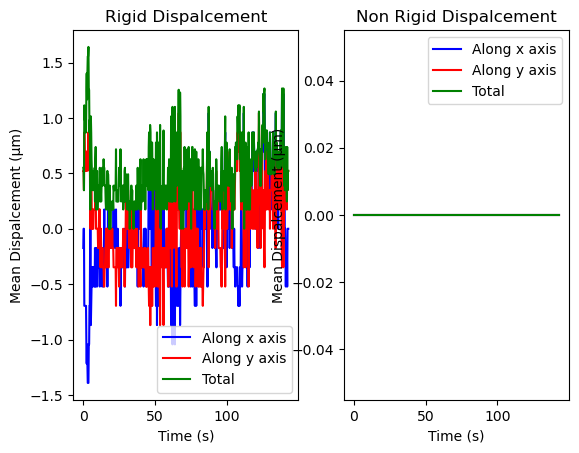

In [12]:
#%% Analyse motion correction
shifts_rig, shits_nr = mc.MotCorr_plots(data_dir.MC_path, basename, 
                                        data_dir.Frame_rate, dxy, min_shift =3)

### Memory mapping 

Save a mmap file and delete the previous one

In [13]:
fname_new = cm.save_memmap(mc.mmap_file, base_name=basename, order='C',
                           border_to_0=border_to_0, dview=dview) # exclude borders
os.remove(mc.mmap_file[0]) #This removes the order F file
    

## <font color=red>Part 2</font>
Run the first 3 cells of part1, then start from here if you want to start again with the neuron detection.

__If you want to start from Part3, you still need to run the first cell of Part2__

You need again to specify if you want to use the saved mmap files for the smoothed (or original) and for the rigid (or not rigid) motion corrected file

In [14]:
use_smooth = True # Decide if to use smoothed or not
pw_rigid = False   # Decide if to use rigid or not

mc_dict = {'pw_rigid': pw_rigid,}
opts, basename = data_dir.save_opt_param(use_smooth, mc_dict)

movie_chosen = glob.glob(data_dir.my_path + '/' + basename + '*.mmap')[0]
Yr, dims, T = cm.load_memmap(movie_chosen)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 

if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

### Now set important parameters for source extraction

The most important one is the neuron diameter in microns

In [15]:
p = 1                    # order of the autoregressive system
gnb = 1                  # number of global background components, better if 2, for paper I used 1
merge_thr = 0.95         # merging threshold, max correlation allowed

neuron_diam_um = 15      # diameter of a neuron in microns. Adjust this parameter if needed (but in general not needed)
K = 3                    # number of components per patch

gSig, stride_cnmf, rf_0 = data_dir.format_segmentation_parameters(neuron_diam_um,
                                                                data_dir.dxy)

# initialization method (if analyzing dendritic data using 'sparse_nmf')
method_init = 'greedy_roi'   #'sparse_nmf'#'greedy_roi'
ssub = 1                     # spatial subsampling during initialization
tsub = 1                     # temporal subsampling during intialization

# parameters for component evaluation
opts_dict = {'p': p,
             'nb': gnb,
             'merge_thr': merge_thr,
             'stride': stride_cnmf,
             'K': K,
             'gSig': gSig,
             'method_init': method_init,
             'rolling_sum': True,
             'ssub': ssub,
             'tsub': tsub}

opts, basename = data_dir.save_opt_param(use_smooth, opts_dict)

### Load or create template to ease neuron detection. <font color='red'>New possibility: load previously saved ROI</font>
There are 3 options: 
1. You start from the video in memory (already motion corrected) and use as template the mean image from it. 
2. You start from a reference image that needs to have the same pixel size as the video and it has to be called __Ref_Image.tif__ and be in the same folder as the data.
3. Load previously saved components. Go in one of the previous analysis, copy the Components.hdf5, or the ComponentsFromTemplate.hdf5 and paste it in the current folder. <font color='red'>Rename it to Ref_components.hdf5</font>

<font color='red'>The first two options only work if use_Previous_ROI = False </font>. Otherwise it only loads ROI from previous acquisition

You can play with three parameters to process the reference/average image and ease the neuronal detection:
__sigma1, threshold1, sqrt1__ for the average image, and 2 for the reference. See what happens as you change them.

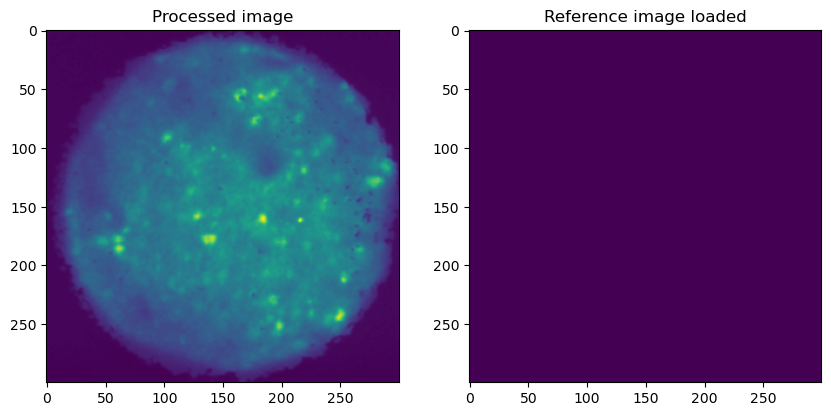

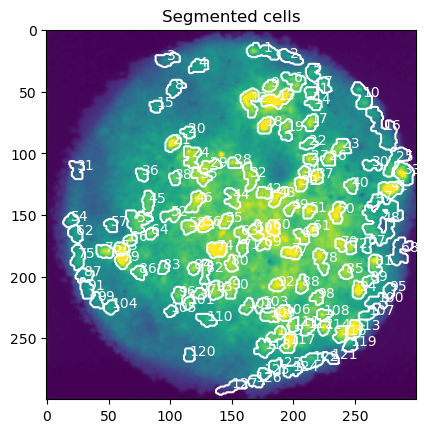

In [17]:
use_Previous_ROI = False # If True, loads ROI from previous acquisition, and skips the reference image

use_Ref_image = False # If True, loads the Ref image, if False takes the average of the video. 
                    # Only if use_Previous_ROI is False

Cn = fendo.produce_template(np.std(images, axis=0), [0,0], 0, False)    

if use_Previous_ROI:
    ROI = cnmf.load_CNMF(data_dir.my_path + 
                                  '/Ref_components.hdf5')
    a = ROI.estimates.A.toarray()
    a =  a > 0
    Ain = a
    if np.shape(a)[0] > np.shape(Cn)[0] * np.shape(Cn)[1]:
        b = np.zeros([np.shape(Cn)[0] * np.shape(Cn)[1], np.shape(a)[1]])
        for i in range(np.shape(a)[1]):
            a_map = np.reshape(a[:,i], [int(np.sqrt(np.shape(a)[0])),int(np.sqrt(np.shape(a)[0]))])
            b_map = fendo.rebin(a_map, [np.shape(Cn)[0], np.shape(Cn)[1]])
            b[:,i] = np.reshape(b_map, np.shape(b)[0])
        Ain = b
    Ain = Ain > 0
    crd = plot_contours(Ain, Cn)
    plt.title('Reloaded cells')
    
else:    
    image_process, image_load = fendo.plot_template_image(
        images, data_dir.my_path, show_fig = True,
        sigma1 = [0,0], threshold1 = 0, sqrt1 = False, 
        sigma2 = [0,0], threshold2 = 0, sqrt2 = False)

    if use_Ref_image:
        mR = image_load 
    else:
        mR = image_process

    if np.mod(gSig[0],2) == 1:
        gSigseed = gSig[0]
    else:
        gSigseed = gSig[0] + 1

    fig1, ax1 =plt.subplots()
    Ain = cm.base.rois.extract_binary_masks_from_structural_channel(
        mR, gSig = gSigseed, expand_method='dilation')[0]
    crd = plot_contours(Ain.astype('float32'), Cn)
    plt.title('Segmented cells')


### Extract components
Here you can decide to perform the source extraction starting from the pre-selected cells above, or from scratch. 

Starting from previously selected cells should be faster and should make sure that the cells that you see (for example the one that we are photstimulating) are found, even if they are not very active.

The cell below gives you the posssibility to calculate two different files for cells that were pre-selected or not.

At the beginning, you can first select `True`, then `Flase` and run the cell twice. This will produce and save both corrections, so that in a second moment you can always decide to re-analyse one or the other.

In [18]:
start_from_template = True

if not os.path.exists(data_dir.Imaging_path):
    os.makedirs(data_dir.Imaging_path)   

if start_from_template:
    rf = None
    only_init = False
    opts_dict = {'rf': rf,'only_init': only_init}
    opts, basename = data_dir.save_opt_param(use_smooth, opts_dict)
    cnm_template = cnmf.CNMF(n_processes, params=opts, dview=dview, Ain=Ain)
    cnm_template.fit(images)
    cnm_template.estimates.Cn = Cn
    cnm_template.save(data_dir.Imaging_path + '/ComponentsFromTemplate.hdf5')
else: 
    rf = rf_0
    only_init = True
    opts_dict = {'rf': rf,'only_init': only_init}
    opts, basename = data_dir.save_opt_param(use_smooth, opts_dict)
    cnm = cnmf.CNMF(n_processes, params=opts, dview=dview)
    cnm.fit(images)
    cnm2 = cnm.refit(images, dview=dview)
    cnm2.estimates.Cn = Cn 
    cnm2.save(data_dir.Imaging_path + '/Components.hdf5')

2024-07-25 15:18:52.187990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 15:18:52.191710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 15:18:52.193241: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


spatial support for each components given by the user


## <font color=red>Part 3</font>

You can at any moment restart the analysis from here using the data previously saved. 
To do that, __run the first 3 cells of Part1, then the cell below 'Part 2' and you are ready to go__

Start from here is you want to change thresholds for SNR or others, from components that were already saved before.

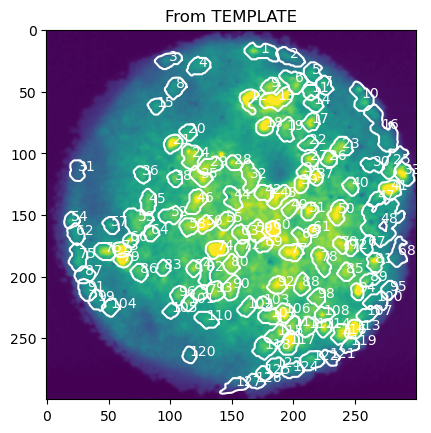

In [19]:
# Load and plot results
if os.path.exists(data_dir.Imaging_path + '/ComponentsFromTemplate.hdf5'):
    cnm_template = cnmf.load_CNMF(data_dir.Imaging_path + 
                                  '/ComponentsFromTemplate.hdf5')
    Cn = cnm_template.estimates.Cn
    cnm_template.estimates.plot_contours(img=Cn)
    plt.title('From TEMPLATE')

if os.path.exists(data_dir.Imaging_path + '/Components.hdf5'):
    cnm2 = cnmf.load_CNMF(data_dir.Imaging_path + '/Components.hdf5')
    Cn = cnm2.estimates.Cn
    cnm2.estimates.plot_contours(img=Cn)
    plt.title('No template')

### Component Evaluation and plot

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier (this represents the similarity to the shape of a neuron)

- We can manually select these thresholds

In [20]:
min_SNR = 2  # signal to noise ratio for accepting a component
rval_thr = 0.85  # space correlation threshold for accepting a component
cnn_thr = 0.9  # threshold for CNN based classifier
cnn_lowest = 0.1 # neurons with cnn probability lower than this value are rejected

quality_dict = {'min_SNR': min_SNR,
                           'rval_thr': rval_thr,
                           'use_cnn': True,
                           'min_cnn_thr': cnn_thr,
                           'cnn_lowest': cnn_lowest}

if 'cnm_template' in locals():
    cnm_template.params.set('quality', quality_dict)
    cnm_template.estimates.evaluate_components(
        images, cnm_template.params, dview=dview)
    cnm_template.estimates.plot_contours(img=Cn,
                                      idx=cnm_template.estimates.idx_components)
    plt.suptitle('Cells found from TEMPLATE \
    \n number of found components: {}'.format(
        np.shape(cnm_template.estimates.idx_components)[0]))


if 'cnm2' in locals():
    cnm2.params.set('quality', quality_dict)
    cnm2.estimates.evaluate_components(images, cnm2.params, dview=dview)
    cnm2.estimates.plot_contours(img=Cn,
                                      idx=cnm2.estimates.idx_components)
    plt.suptitle('Cells found no template\
    \n number of found components: {}'.format(
        np.shape(cnm2.estimates.idx_components)[0]))


opts, basename = data_dir.save_opt_param(use_smooth, quality_dict)

GPU run not requested, disabling use of GPUs
USING MODEL (tensorflow API): /Users/nicoloaccanto/caiman_data/model/cnn_model.h5.pb


AttributeError: module 'tensorflow' has no attribute 'gfile'

### Decide which file to use, you can always change later

In [54]:
use_template = True
if use_template:
    cnm_final = cnm_template
else:
    cnm_final = cnm2

In [55]:
# accepted components
cnm_final.estimates.nb_view_components(
    img=Cn, idx=cnm_final.estimates.idx_components,denoised_color='red')

In [98]:
# rejected components
if len(cnm_final.estimates.idx_components_bad) > 0:
    cnm_final.estimates.nb_view_components(
        img=Cn, idx=cnm_final.estimates.idx_components_bad, denoised_color='red')
else:
    print("No components were rejected.")

## <font color=red>For photostimulation only</font>


Check if cells stimulated are included or if not

For this enter manually, or in the future we can automatize this, the coordinates of the photostimulation spots

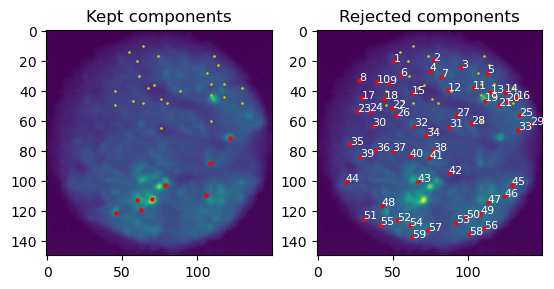

In [58]:
centerROI = cm.base.rois.com(
    cnm_final.estimates.A,dims[0],dims[1],1) #Center of mass of all the cells found

centerROI_kept = cm.base.rois.com(
    cnm_final.estimates.A[:,cnm_final.estimates.idx_components],
                             dims[0],dims[1],1) #Center of mass of all the cells found
centerROI_rejected = cm.base.rois.com(
    cnm_final.estimates.A[:,cnm_final.estimates.idx_components_bad],
                             dims[0],dims[1],1) #Center of mass of all the cells found

coo_spots = data_dir.xy_photostim/2

fig1, ax1 = plt.subplots(1,2)
ax1[0].imshow(Cn)
ax1[0].scatter(centerROI_kept[:,1], centerROI_kept[:,0], color = 'r', marker = 'o', s = 5)
ax1[0].scatter(coo_spots[:,0], coo_spots[:,1], color = 'y', marker = '*', s = 1)
ax1[0].set_title('Kept components')

ax1[1].imshow(Cn)
ax1[1].scatter(centerROI_rejected[:,1],
               centerROI_rejected[:,0], color = 'r', marker = 'o', s = 5)
ax1[1].scatter(coo_spots[:,0], coo_spots[:,1],
               color = 'y', marker = '*', s = 1)
ax1[1].set_title('Rejected components')
for i in range(len(centerROI_rejected)):
    x = centerROI_rejected[i,1]
    y = centerROI_rejected[i,0]
    ax1[1].text(x, y, i + 1, fontsize=8, color = 'w')

### Extract DF/F values

In [33]:
#%% Extract DF/F values
cnm_final.estimates.detrend_df_f(quantileMin=8, frames_window=250)

### Remove accepted components by hand

This cell is __optional__

If you write __to_remove = np.array([0])__(with only zero value), it will not remove anything. Same for restore. So you can remove something without restoring anything or the viceversa

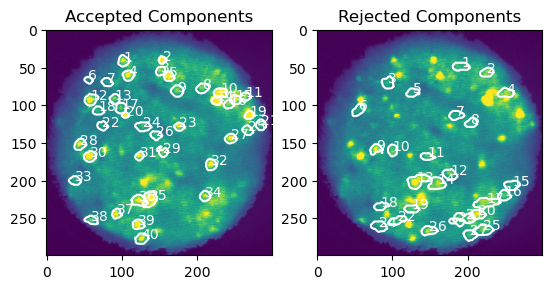

In [149]:
to_remove = np.array([0]) # Chose elements from accepted components
                          #that you don't want, if none, then put np.array([0])
to_restore = np.array([0]) # Chose elements from rejected components to restore,
                            #if non then use np.array([0])

cnm_final.estimates.idx_components, cnm_final.estimates.idx_components_bad = \
    fendo.remove_restore_comp(to_remove, to_restore, cnm_final)

# Now can go back up to display neurons accepted/rejected

#%% PLOT COMPONENTS
cnm_final.estimates.plot_contours(
    img = Cn, idx=cnm_final.estimates.idx_components)

### Select only high quality components

This will save another hdf5 file in which only the accepted components are are saved. One can always go back and reload the original hdf5 at the Part3 start

In [34]:
cnm_final.estimates.select_components(use_object = True)
cnm_final.save(data_dir.Imaging_path + 
                                  '/manually_inspected_components.hdf5')

### Stop cluster and clean up log files

In [35]:
#%% STOP CLUSTER and clean up log files
if 'dview' in locals():
    cm.stop_server(dview=dview)

log_files = glob.glob('*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

### View movie with the results
We can inspect the denoised results by reconstructing the movie and playing alongside the original data and the resulting (amplified) residual movie

In [ ]:
cnm_final.estimates.play_movie(images, q_max=99.9, gain_res=2,
                                  magnification=2,
                                  include_bck=False)

In [34]:
#%% reconstruct denoised movie
denoised = cm.movie(cnm_final.estimates.A.dot(cnm_final.estimates.C) + \
                    cnm_final.estimates.b.dot(cnm_final.estimates.f)).reshape(
    dims + (-1,), order='F').transpose([2, 0, 1])

tf.imwrite(data_dir.Imaging_path + 
                                  '/Denoised.tif', denoised)

## <font color=red>Part 4</font>
 
If the file manually_inspected_components was saved, Part4 produces some plots.

For starting back from here, __you only need to runthe first 3 cells of Part1 and the first of Part2__

/Users/nicolo/Documents/GitHub/CaImAn/caiman/fendo_functions.py:423: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.Sec_1st_part = float(data_photostim.T['Sec 1st part'])
/Users/nicolo/Documents/GitHub/CaImAn/caiman/fendo_functions.py:424: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.Photostim_pulses = int(data_photostim.T['N Pulses'])
/Users/nicolo/Documents/GitHub/CaImAn/caiman/fendo_functions.py:425: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.Photostim_Rep = int(data_photostim.T['Repetitions'])


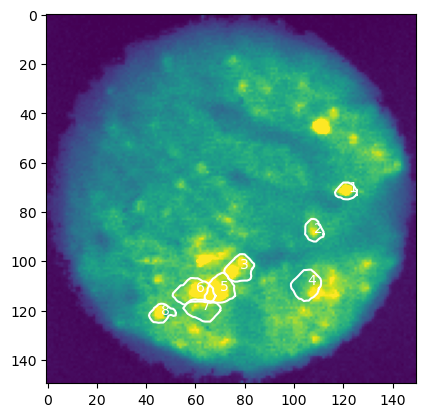

In [36]:
if os.path.exists(data_dir.Imaging_path + '/manually_inspected_components.hdf5'):
    cnm_final = cnmf.load_CNMF(data_dir.Imaging_path + 
                                  '/manually_inspected_components.hdf5')
    Cn = cnm_final.estimates.Cn
    cnm_final.estimates.plot_contours(img=Cn)
    
data_analysis = fendo.components_analysis(cnm_final, data_dir)
    

### Calculate SNR and plot components

Change some of the parameters below to change the plots

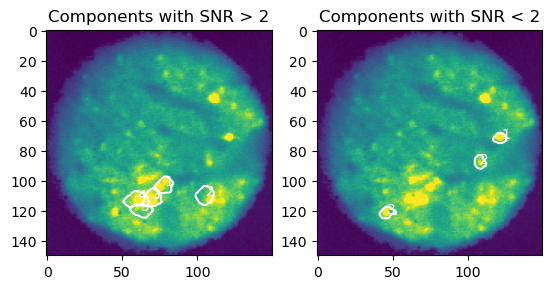

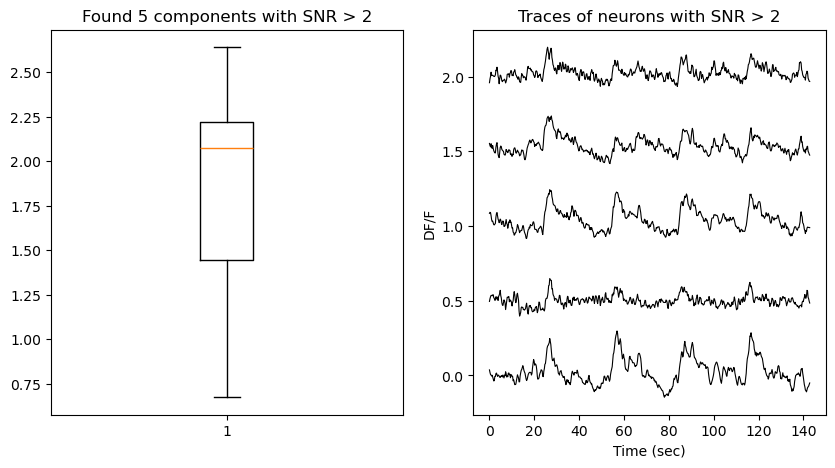

In [37]:
SNR_thresh = [2] # Plot only cells with SNR> some value. You can decide more than one value
ver_shift = 0.5 # Change this if you want the different curves to be more or less spaces
smooth_tresh = 6  # Change this if <=2 no smoothing, if > 2 you can decide the smooth level

neurons_SNR, coor_SNR = data_analysis.plot_SNR(SNR_thresh, ver_shift, smooth_tresh)

### Plot traces from the cells you want

You can use this function to plot traces of the cells you want. You will be able to plot different FOVs (change the rows number to create more or less). On each FOV you will see the cells you have selected in cells1, cells2 (add more if you want more) and on the side you will see the traces

In [ ]:
rows = 2
cells1 = [0, 10, 5]
cells2 = [3, 4, 8, 9]
cells = [cells1, cells2]
color_points = ['white','white']
colors_lines = ['black', 'red']
legend = ['Cells1', 'Cells2']
title = 'My_figure'
savefigure = True

data_analysis.plot_FOV_traces(rows, cells, color_points, colors_lines, legend, 
                              smooth_tresh, ver_shift, title, savefigure)


### Here you perform the photostim analysis and plot graphs

There are few parameters to select, take a moment to see what they all do.

They are alslo automatically saved everytime you run the function do_photostim_analysis

In [57]:
flip = True #Try False if distances are not well calculated

thresh_dist = 12 #threshold distance in µm, cells that are closer than this
                 #value to photostimulated spots are considered targeted
    
time_period = 3 # seconds, both for the baseline and photostim, this can be changed

Diff_STD = 3 # How many STD outside the noise to consider Photostimulated

ver_shift = 0.5 # Change this if you want the different curves in plots to be more or less spaced


# Function that performs the analysis
data_analysis.do_photostim_analysis(flip, thresh_dist, time_period, 
                                    Diff_STD)

### Make and save all the useful plots

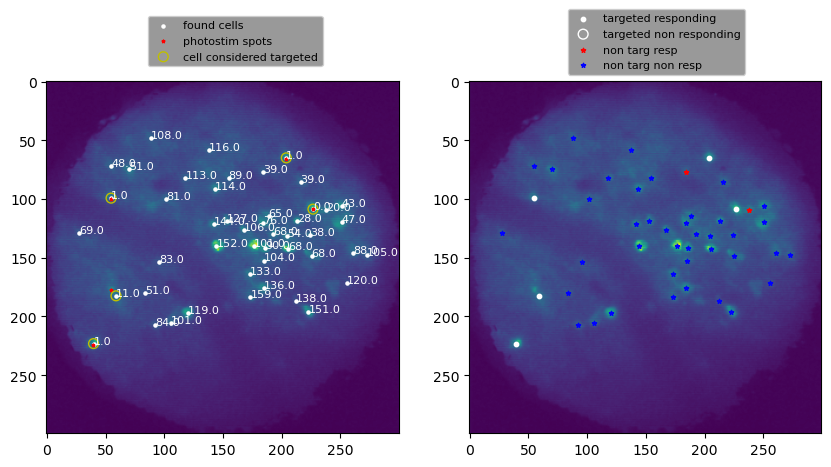

In [59]:
#%% To plot cell targered, responding etc
data_analysis.plot_targeted_cells(save_figure = True)

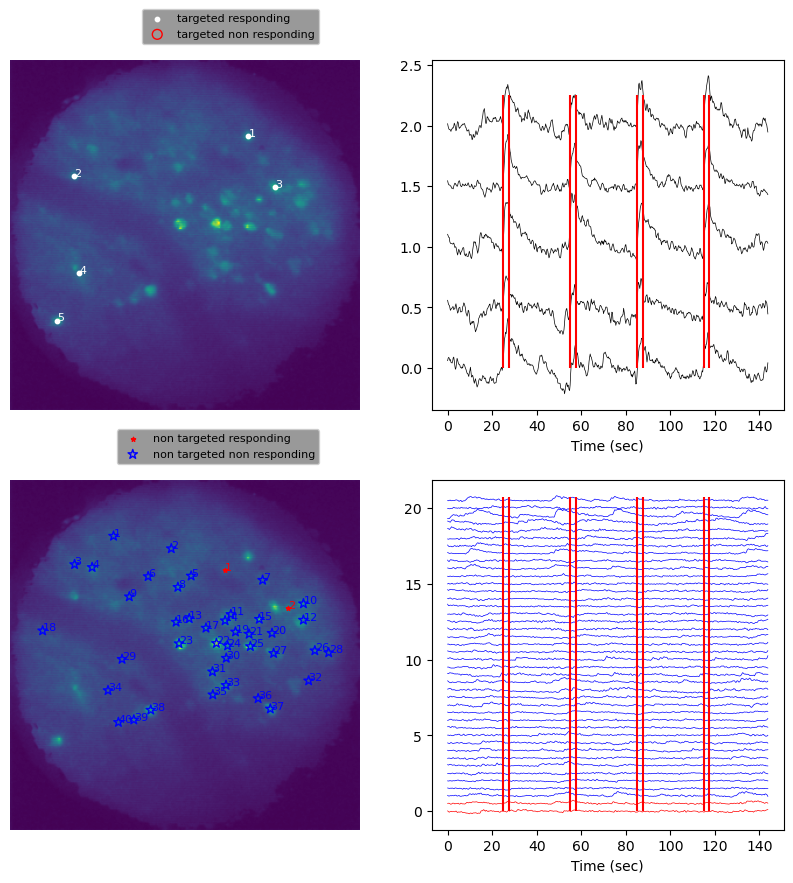

In [48]:
#%% To plot photostim traces 
data_analysis.plot_photostim_traces(ver_shift, smooth_tresh,save_figure = True)

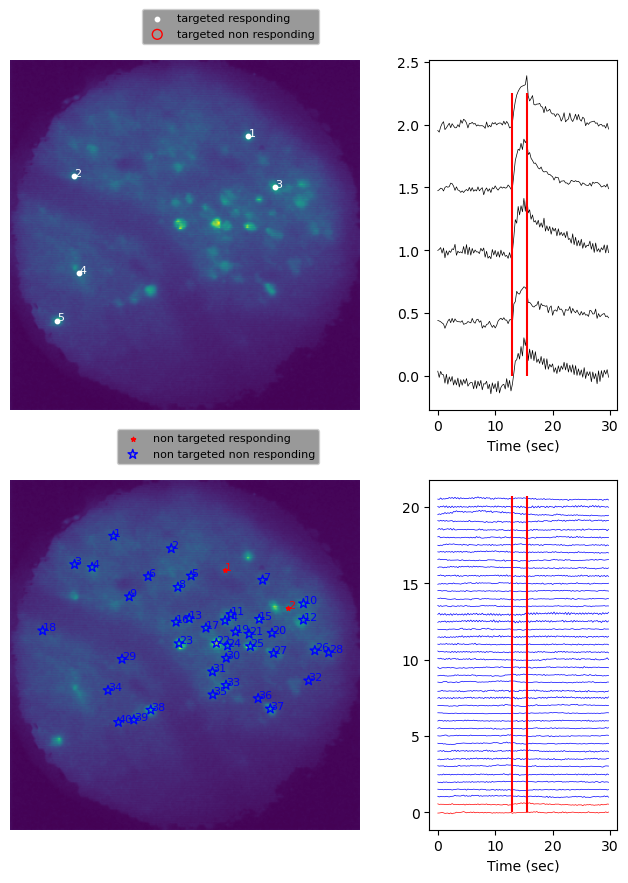

In [50]:
#%% To plot averaged photostim traces
data_analysis.plot_photostim_traces(ver_shift, smooth_tresh,
                                    save_figure = True, average = True)


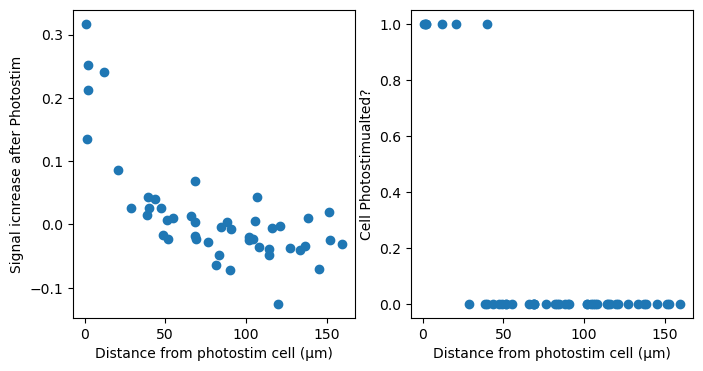

In [49]:
#%% Plot graphs on lateral resolution of photostim
data_analysis.plot_photostim_lateral_resolution(save_figure = True)